#### Imports

In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.interpolate import interp1d

# For orbits
import astrospice 
for sc in ['psp','solar orbiter'] : kernels = astrospice.registry.get_kernels(sc,'predict') 
    
# Useful astropy things
import astropy.units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord

# For PSP Data
import pyspedas, pytplot

# Sunpy and Sunpy-SOAR
import sunpy_soar
from sunpy.net import Fido
import sunpy.net.attrs as a
import sunpy.coordinates

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

/home/sbadman/anaconda3/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
Exception ignored in: <function BaseEventLoop.__del__ at 0x7f6762ed4160>
Traceback (most recent call last):
  File "/home/sbadman/anaconda3/lib/python3.9/asyncio/base_events.py", line 688, in __del__
    self.close()
  File "/home/sbadman/anaconda3/lib/python3.9/asyncio/unix_events.py", line 61, in close
    self.remove_signal_handler(sig)
  File "/home/sbadman/anaconda3/lib/python3.9/asyncio/unix_events.py", line 150, in remove_signal_handler
    signal.signal(sig, handler)
  File "/home/sbadman/anaconda3/lib/python3.9/signal.py", line 56, in signal
    handler = _signal.signal(_enum_to_int(signalnum), _enum_to_int(handler))
ValueError: signal only works in main thread of the main interpreter


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

### Download and load data

In [2]:
dt_start,dt_end = datetime.datetime(2022,2,21),datetime.datetime(2022,3,3)

#### Download/Load PSP/SPAN-i (pyspedas)

In [3]:
psp_spi_VEL_RTN_SUN = pyspedas.psp.spi([dt_start,dt_end],notplot=True)['psp_spi_VEL_RTN_SUN']
psp_vr_dt = psp_spi_VEL_RTN_SUN['x'] # Datetimes
psp_vr_ts = np.array([dt.timestamp() for dt in psp_vr_dt]) # Unix Timestamp (float)
psp_vr = psp_spi_VEL_RTN_SUN['y'][:,0]

#Remove NaNs for interpolation
psp_nans = np.isnan(psp_vr)
psp_vr_dt = psp_vr_dt[~psp_nans]
psp_vr_ts = psp_vr_ts[~psp_nans]
psp_vr = psp_vr[~psp_nans]

11-Apr-23 15:53:45: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spi/l3/spi_sf00_l3_mom/2022/
11-Apr-23 15:53:45: File is current: psp_data/sweap/spi/l3/spi_sf00_l3_mom/2022/psp_swp_spi_sf00_l3_mom_20220221_v04.cdf


Using LEVEL=L3


11-Apr-23 15:53:46: File is current: psp_data/sweap/spi/l3/spi_sf00_l3_mom/2022/psp_swp_spi_sf00_l3_mom_20220222_v04.cdf
11-Apr-23 15:53:46: File is current: psp_data/sweap/spi/l3/spi_sf00_l3_mom/2022/psp_swp_spi_sf00_l3_mom_20220223_v04.cdf
11-Apr-23 15:53:46: File is current: psp_data/sweap/spi/l3/spi_sf00_l3_mom/2022/psp_swp_spi_sf00_l3_mom_20220224_v04.cdf
11-Apr-23 15:53:46: File is current: psp_data/sweap/spi/l3/spi_sf00_l3_mom/2022/psp_swp_spi_sf00_l3_mom_20220225_v04.cdf
11-Apr-23 15:53:46: File is current: psp_data/sweap/spi/l3/spi_sf00_l3_mom/2022/psp_swp_spi_sf00_l3_mom_20220226_v04.cdf
11-Apr-23 15:53:46: File is current: psp_data/sweap/spi/l3/spi_sf00_l3_mom/2022/psp_swp_spi_sf00_l3_mom_20220227_v04.cdf
11-Apr-23 15:53:46: File is current: psp_data/sweap/spi/l3/spi_sf00_l3_mom/2022/psp_swp_spi_sf00_l3_mom_20220228_v04.cdf
11-Apr-23 15:53:46: File is current: psp_data/sweap/spi/l3/spi_sf00_l3_mom/2022/psp_swp_spi_sf00_l3_mom_20220301_v04.cdf
11-Apr-23 15:53:46: File is curr

#### Download/Loal SolO/SWA-PAS

Note : pyspedas/pytplot works well for PSP, but does not have good functionality for SolO yet. This is a shame since pyspedas does the download and loading in one swoop.

Instead we need to use sunpy-soar to do the download, and use pytplot to load in the files afterwards.

In [4]:
# Prepare search for MAG data files
instrument = a.Instrument('SWA')
time = a.Time(dt_start,dt_end)
level = a.Level(2)
product = a.soar.Product('SWA-PAS-GRND-MOM')

# # Perform search for MAG data files
result = Fido.search(instrument & time & level & product)
files = sorted(Fido.fetch(result)) # sort to get in ascending date order

## Load in CDF Files
solo_swa_pas_V_RTN = pytplot.cdf_to_tplot(files,notplot=True)["V_RTN"]
solo_vr_dt = solo_swa_pas_V_RTN['x']# Datetimes
solo_vr_ts = np.array([dt.timestamp() for dt in solo_vr_dt]) # Unix Timestamp (float)
solo_vr = solo_swa_pas_V_RTN['y'][:,0]

#Remove NaNs for interpolation
solo_nans = np.isnan(solo_vr)
solo_vr_dt = solo_vr_dt[~solo_nans]
solo_vr_ts = solo_vr_ts[~solo_nans]
solo_vr = solo_vr[~solo_nans]

Files Downloaded:   0%|          | 0/11 [00:00<?, ?file/s]

### Downsample timeseries to a common set of timestamps

We use interpolation (`scipy.interpolate.interp1d`) to take the input timeseries and reduce the cadence down to a set of common timestamps (hourly) for which it is tractable to generate spacecraft trajectories and Parker spirals

In [5]:
def gen_dt_arr(dt_init,dt_final,cadence_days=1) :
    """
    Get array of datetime.datetime from {dt_init} to {dt_final} every 
    {cadence_days} days
    """
    dt_list = []
    while dt_init < dt_final :
        dt_list.append(dt_init)
        dt_init += datetime.timedelta(days=cadence_days)
    return np.array(dt_list)

dt_common = gen_dt_arr(dt_start, dt_end, cadence_days=1/48)
ts_common = np.array([dt.timestamp() for dt in dt_common])

In [6]:
psp_vr_common = interp1d(psp_vr_ts,psp_vr,bounds_error=False)(ts_common)*u.km/u.s
solo_vr_common = interp1d(solo_vr_ts,solo_vr,bounds_error=False)(ts_common)*u.km/u.s

#### View the data and the effect of interpolation

Text(0.5, 1.0, 'Parker')

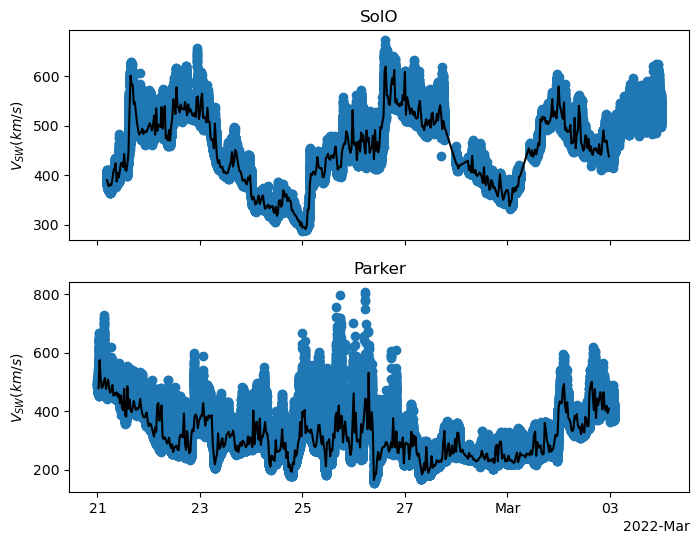

In [7]:
fig,axes = plt.subplots(figsize=(8,6),nrows=2,sharex=True)

axes[0].plot(dt_common,solo_vr_common,zorder=5,color="black")
axes[0].scatter(solo_vr_dt,solo_vr)

axes[1].plot(dt_common,psp_vr_common,zorder=5,color="black")
axes[1].scatter(psp_vr_dt,psp_vr)

for ax in axes: ax.set_ylabel("$V_{SW} (km/s)$")
axes[0].set_title("SolO")
axes[1].set_title("Parker")

### Generate spacecraft trajectories over the interval [dt_start,dt_end]

In [8]:
### Create SkyCoord for PSP in the inertial (J2000) frame
psp_inertial = astrospice.generate_coords(
    'SOLAR PROBE PLUS',dt_common
)
### Transform to solar co-rotating frame 
psp_carrington = psp_inertial.transform_to(
    sunpy.coordinates.HeliographicCarrington(observer="self")
)

### Create SkyCoord for SolO in the inertial (J2000) frame
solo_inertial = astrospice.generate_coords(
    'Solar Orbiter',dt_common
)
### Transform to solar co-rotating frame 
solo_carrington = solo_inertial.transform_to(
    sunpy.coordinates.HeliographicCarrington(observer="self")
)

### Ballistically Project Trajectories to Source Surface / 2.5 Rs

In [9]:
# Functions from https://github.com/STBadman/PSP_E10_Sources/blob/main/helpers.py

@u.quantity_input
def delta_long(r:u.R_sun,
               r_inner=2.5*u.R_sun,
               vsw=360.*u.km/u.s,
               omega_sun=14.713*u.deg/u.d,
               ):
    """ 
    Ballistic longitudinal shift of a Parker spiral connecting two
    points at radius r and r_inner, for a solar wind speed vsw. Solar
    rotation rate is also tunable
    """
    return (omega_sun * (r - r_inner) / vsw).to("deg")

def ballistically_project(skycoord,r_inner = 2.5*u.R_sun, vr_arr=None) :
    """
    Given a `SkyCoord` of a spacecraft trajectory in the Carrington frame,
    with `representation_type="spherical"`, and optionally an array of
    measured solar wind speeds at the same time intervals of the trajectory,
    return a SkyCoord for the trajectory ballistically projected down to 
    `r_inner` via a Parker spiral of the appropriate curvature. When `vr_arr`
    is not supplied, assumes wind speed is everywhere 360 km/s
    """
    if vr_arr is None : vr_arr = np.ones(len(skycoord))*360*u.km/u.s
    lons_shifted = skycoord.lon + delta_long(skycoord.radius,
                                             r_inner=r_inner,
                                             vsw=vr_arr
                                            )
    return SkyCoord(
        lon = lons_shifted, 
        lat = skycoord.lat,
        radius = r_inner * np.ones(len(skycoord)),
        representation_type="spherical",
        frame = skycoord.frame
    )

In [10]:
psp_projected = ballistically_project(psp_carrington,vr_arr=psp_vr_common)
solo_projected = ballistically_project(solo_carrington,vr_arr=solo_vr_common)

### Create Parker Spirals
##### Last bit of legwork then on to the plot! 

In [11]:
def parker_streamline(phi0=0.0*u.deg,
                      r0=1.0*u.R_sun,
                      w_s=(2.*np.pi)/(24.47*(24*3600))*u.rad/u.s,
                      v_sw=360*u.km/u.s,
                      rmax=215*u.R_sun,
                      sampling=500,
                     ) :
    """Starting from an inner polar coordinatate ({r0},{phi0}), trace
    a ballistic spiral out to {rmax} with curvature set by a solar wind
    speed of {v_sw} with {sampling} gridpoints
    """
    # Output r :: Rs, phi :: deg
    r = np.linspace(r0,rmax,sampling)
    phi = -w_s/v_sw*(r-r0) + phi0
    return r.to("R_sun"),phi.to("deg")

In [12]:
psp_streamlines = [
    parker_streamline(
        phi0=projected_coord.lon,
        r0 = projected_coord.radius,
        v_sw = v)
    for projected_coord,v in zip(psp_projected,psp_vr_common)]
solo_streamlines = [
    parker_streamline(
        phi0=projected_coord.lon,
        r0 = projected_coord.radius,
        v_sw = v)
    for projected_coord,v in zip(solo_projected,solo_vr_common)]

### We've now generated everything we need to make the figure

11-Apr-23 15:53:55: posx and posy should be finite values
11-Apr-23 15:53:55: posx and posy should be finite values
11-Apr-23 15:53:55: posx and posy should be finite values
11-Apr-23 15:53:55: posx and posy should be finite values


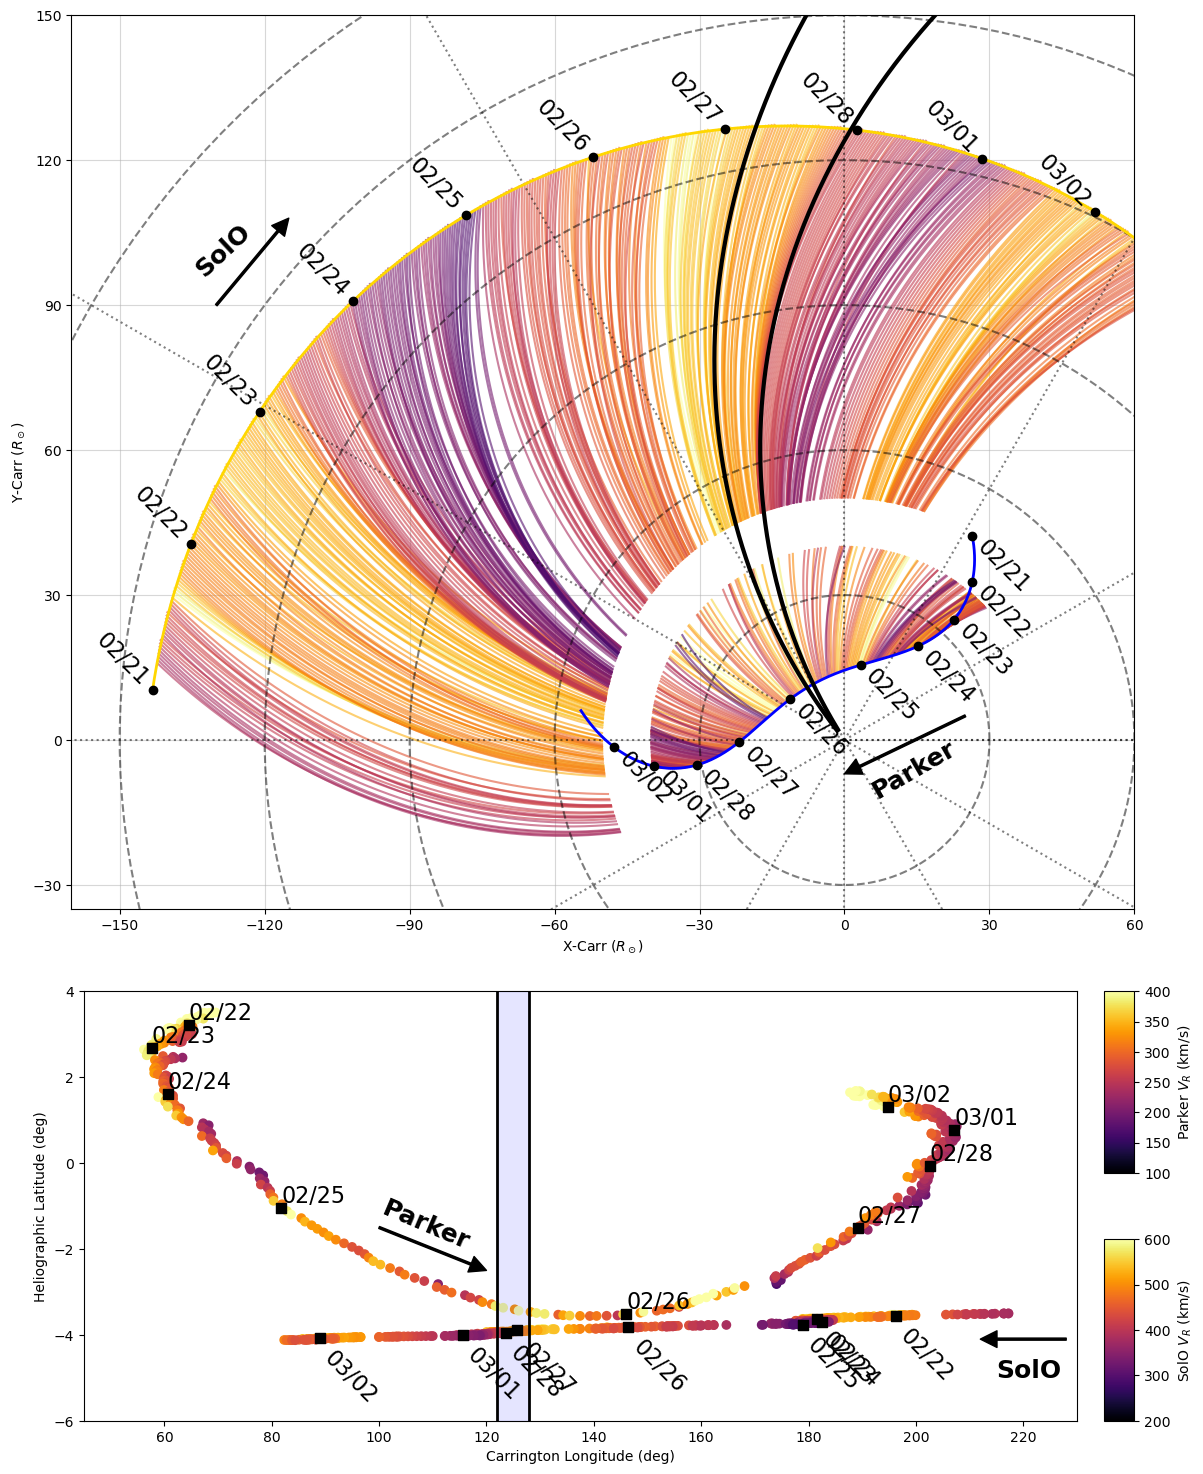

In [13]:
### Set up panels
fig = plt.figure(figsize=(12,15))
gs = GridSpec(6,24,figure=fig)
axes = np.array(
    [fig.add_subplot(gs[0:4,:]),
     fig.add_subplot(gs[4:,0:23]),
     fig.add_subplot(gs[4,-1]),
     fig.add_subplot(gs[5,-1])
    ]
)

### TOP PANEL ####

### Plot trajectories and annotate dates
label_cadence = 48 # Every 24 hours

psp_carrington.representation_type="cartesian"
axes[0].plot(
    psp_carrington.x.to("R_sun"),
    psp_carrington.y.to("R_sun"),
    color="blue",linewidth=2,label="PSP",zorder=10
)
axes[0].scatter(
    psp_carrington.x.to("R_sun")[::label_cadence],
    psp_carrington.y.to("R_sun")[::label_cadence],
    color="black",zorder=10
)

solo_carrington.representation_type="cartesian"
axes[0].plot(
    solo_carrington.x.to("R_sun"),
    solo_carrington.y.to("R_sun"),
    color="gold",linewidth=2,label="SolO",zorder=10
)
axes[0].scatter(
    solo_carrington.x.to("R_sun")[::label_cadence],
    solo_carrington.y.to("R_sun")[::label_cadence],
    color="black",zorder=10
)


for dt,pspc,soc in zip(dt_common[::label_cadence],
                       psp_carrington[::label_cadence],
                       solo_carrington[::label_cadence]) :
    axes[0].text(pspc.x.to("R_sun").value,
                 pspc.y.to("R_sun").value,
                f"{dt.month:02d}/{dt.day:02d}",rotation=-45,color="black",
                verticalalignment="top",
                horizontalalignment="left",zorder=10,fontsize=16
               )
    axes[0].text(soc.x.to("R_sun").value,
                 soc.y.to("R_sun").value,
                 f"{dt.month:02d}/{dt.day:02d}",rotation=-45,color="black",
                 verticalalignment="bottom",
                 horizontalalignment="right",zorder=10,
                 fontsize=16
               )

# Draw Parker Spiral Lines
normsolo=plt.Normalize(200,600) # Normalize SolO and PSP data separately due to acceleration
normpsp=plt.Normalize(100,400)
rminsolo = 50*u.R_sun # Truncate spirals so they don't overlap
rmaxpsp = 40*u.R_sun
psp_carrington.representation_type="spherical"
solo_carrington.representation_type="spherical"
for psp_spiral,solo_spiral,psp_v,solo_v,pspc,soloc in zip(
        psp_streamlines,solo_streamlines,
        psp_vr_common, solo_vr_common,
        psp_carrington, solo_carrington
    ):
    psp_spiral_inds =  ((psp_spiral[0] > pspc.radius) 
                        & (psp_spiral[0] < rmaxpsp))
    axes[0].plot((psp_spiral[0]*np.cos(psp_spiral[1]))[psp_spiral_inds],
                 (psp_spiral[0]*np.sin(psp_spiral[1]))[psp_spiral_inds],
                 color = plt.cm.inferno(normpsp(psp_v.value)),alpha=0.6
                ) 
    solo_spiral_inds =  ((solo_spiral[0] > rminsolo) 
                        & (solo_spiral[0] < soloc.radius))
    axes[0].plot((solo_spiral[0]*np.cos(solo_spiral[1]))[solo_spiral_inds],
                 (solo_spiral[0]*np.sin(solo_spiral[1]))[solo_spiral_inds],
                 color = plt.cm.inferno(normsolo(solo_v.value)),alpha=0.6
                ) 

### Anotate stream of interest from Rivera+
parker = parker_streamline(
        phi0= 122*u.deg,
        r0 = 2.5*u.R_sun,
        rmax = 200*u.R_sun ,
        v_sw=450*u.km/u.s
    )
axes[0].plot(parker[0]*np.cos(parker[1]),
            parker[0]*np.sin(parker[1]),
            color = "black",linewidth=3,zorder=20
           ) 
parker = parker_streamline(
        phi0= 128*u.deg,
        r0 = 2.5*u.R_sun,
        rmax = 200*u.R_sun ,
        v_sw=500*u.km/u.s
    )
axes[0].plot(parker[0]*np.cos(parker[1]),
            parker[0]*np.sin(parker[1]),
            color = "black",linewidth=3,zorder=20
           ) 

### Gridlines / Axis Lables ETC for axes[0]
axes[0].set_aspect(1)
rgrids = [30,60,90,120,150,180] 
for R_ in rgrids  :
    axes[0].plot(R_*np.cos(np.linspace(0,2*np.pi,200)),
            R_*np.sin(np.linspace(0,2*np.pi,200)),
            color="black",linestyle="--",alpha=0.5
           )
rmax=200    
for phi in np.radians(np.linspace(0,360,13)) :
    axes[0].plot([0,rmax*np.cos(phi)],[0,rmax*np.sin(phi)],
            color="black",linestyle=":",alpha=0.5
           )
axes[0].set_xticks(np.linspace(-180,180,13))
axes[0].set_yticks(np.linspace(-180,180,13))
axes[0].set_xlim([-160,60])
axes[0].set_ylim([-35,150])
axes[0].grid(alpha=0.5)   
axes[0].set_xlabel("X-Carr ($R_\odot$)")
axes[0].set_ylabel("Y-Carr ($R_\odot$)")

# Annotate spacecraft motion
axes[0].text(-122,96,"SolO",fontsize=18,weight="bold",rotation=43,horizontalalignment="right")
axes[0].annotate(None,(-115,108),(-130,90),arrowprops=dict(facecolor='black',width=1.5))
axes[0].text(5,-12,"Parker",fontsize=18,weight="bold",rotation=30)
axes[0].annotate(None,(0,-7),(25,5),arrowprops=dict(facecolor='black',width=1.5))

#### BOTTOM PANEL #####
axes[1].scatter(
    psp_projected.lon.to("deg")[::48],
    psp_projected.lat.to("deg")[::48]+0.3*u.deg,
    color="black",zorder=10,marker='s',s=50
)

axes[1].scatter(
    solo_projected.lon.to("deg")[::48],
    solo_projected.lat.to("deg")[::48],
    color="black",zorder=10,marker='s',s=50
)

for dt,pspc,soc in zip(dt_common[::48],
                       psp_projected[::48],
                       solo_projected[::48]) :
    axes[1].text(pspc.lon.value,
            pspc.lat.value+0.3,
            f"{dt.month:02d}/{dt.day:02d}",
            rotation=0,color="black",
            verticalalignment="bottom",horizontalalignment="left",zorder=10,
            fontsize=16
           )
    axes[1].text(soc.lon.value,
            soc.lat.value-0.2,
            f"{dt.month:02d}/{dt.day:02d}",
            rotation=-45,color="black",
            verticalalignment="top",horizontalalignment="left",zorder=10,
            fontsize=16
           )

cpsp=axes[1].scatter(psp_projected.lon,
                     psp_projected.lat+0.3*u.deg,               
                     c=psp_vr_common.value,
                     norm = normpsp,
                     cmap="inferno"
                  )
csolo=axes[1].scatter(solo_projected.lon,
                      solo_projected.lat,               
                      c=solo_vr_common.value,
                      norm = normsolo,
                      cmap="inferno"
                    )

### Anotate colorbars

plt.colorbar(cpsp,cax=axes[2],label="Parker $V_R$ (km/s)")
plt.colorbar(csolo,cax=axes[3],label="SolO $V_R$ (km/s)")

# Bottom panel formatting and labeling
axes[1].set_aspect(8)
axes[1].set_ylim(-6,4)
axes[1].set_xlabel("Carrington Longitude (deg)")
axes[1].set_ylabel("Heliographic Latitude (deg)")
axes[1].set_xticks(np.linspace(60,220,9))
axes[1].set_xlim(45,230)
axes[1].axvspan(122,128,alpha=0.1,color="blue")
axes[1].axvline(122,color='black',linewidth=2)
axes[1].axvline(128,color="black",linewidth=2)

#### Annotate spacecraft motion
axes[1].text(215,-5,"SolO",fontsize=18,weight="bold")
axes[1].annotate(None,(212,-4.1),(228,-4.1),arrowprops=dict(facecolor='black',width=1.5))
axes[1].text(100,-2,"Parker",fontsize=18,weight="bold",rotation=-23)
axes[1].annotate(None,(120,-2.5),(100,-1.5),arrowprops=dict(facecolor='black',width=1.5))
#######

plt.tight_layout()